In [1]:
import tensorflow as tf
print(tf.__version__)
from sklearn import manifold
import itertools

import json
from tqdm import tqdm 

from sklearn.metrics import confusion_matrix,f1_score,accuracy_score
from scipy import interp
from PIL import Image, ImageEnhance, ImageOps
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt2
import collections
from sklearn.preprocessing import label_binarize
import math
import random
from keras.applications.inception_v3 import InceptionV3 as iv3
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import VGG19

from keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.applications.EfficientNetB7 import EfficientNetB7
from keras.applications.densenet import DenseNet121
from keras import layers
from keras.layers import GlobalAveragePooling2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as ivr2
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K
import os, os.path
import gc
import time
from keras.preprocessing.image import ImageDataGenerator
import efficientnet.keras as efn 
from efficientnet.keras import center_crop_and_resize, preprocess_input
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

tf.compat.v1.disable_eager_execution()
random.seed(5478)


1.15.5


Using TensorFlow backend.


In [2]:
size = 224
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

class Rand_Augment():
    def __init__(self, Numbers=None, max_Magnitude=None):
        self.transforms = [
                            'autocontrast', 
                           'equalize', 
                           'rotate', 
                           'solarize', 
                           'color', 
                           'posterize',
                           'contrast', 
                           'brightness', 
                           'sharpness', 
                           'shearX', 
                           'shearY', 
                           'translateX', 
                           'translateY',
                            "invert"
                          ]
        if Numbers is None:
            self.Numbers = len(self.transforms) // 2
        else:
            self.Numbers = Numbers
        if max_Magnitude is None:
            self.max_Magnitude = 10
        else:
            self.max_Magnitude = max_Magnitude
        fillcolor = 128
        self.ranges = {
            # these  Magnitude   range , you  must test  it  yourself , see  what  will happen  after these  operation ,
            # it is no  need to obey  the value  in  autoaugment.py
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 0.3, 10),
            "translateY": np.linspace(0, 0.3, 10),
            "rotate": np.linspace(0,5 , 10),
            "color": np.linspace(0.0, 0.3, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 231, 10),
            "contrast": np.linspace(0.0, 0.3, 10),
            "sharpness": np.linspace(0.0, 0.3, 10),
            "brightness": np.linspace(0.0, 0.3, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,           
            "invert": [0] * 10
        }
        self.func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fill=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fill=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fill=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fill=fillcolor),
            "rotate": lambda img, magnitude: self.rotate_with_fill(img, magnitude),
            # "rotate": lambda img, magnitude: img.rotate(magnitude * random.choice([-1, 1])),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: img,
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

    def rand_augment(self):
        """Generate a set of distortions.
             Args:
             N: Number of augmentation transformations to apply sequentially. N  is len(transforms)/2  will be best
             M: Max_Magnitude for all the transformations. should be  <= self.max_Magnitude """

        M = np.random.randint(0, self.max_Magnitude, self.Numbers)

        sampled_ops = np.random.choice(self.transforms, self.Numbers)
        return [(op, Magnitude) for (op, Magnitude) in zip(sampled_ops, M)]

    def __call__(self, image):
        operations = self.rand_augment()
        for (op_name, M) in operations:
            operation = self.func[op_name]
            mag = self.ranges[op_name][M]
            image = operation(image, mag)
        return image

    def rotate_with_fill(self, img, magnitude):
        #  I  don't know why  rotate  must change to RGBA , it is  copy  from Autoaugment - pytorch
        rot = img.convert("RGBA").rotate(magnitude)
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

    def test_single_operation(self, image, op_name, M=-1):
        '''
        :param image: image
        :param op_name: operation name in   self.transforms
        :param M: -1  stands  for the  max   Magnitude  in  there operation
        :return:
        '''
        operation = self.func[op_name]
        mag = self.ranges[op_name][M]
        image = operation(image, mag)
        return image
randaugment = Rand_Augment()
def preprocessing_function(image):
    image = Image.fromarray(image.astype(np.uint8))
    image = np.array(randaugment(image))
    return image

def get_feature(select_pre,train):
    pre_trained_model = select_pre(weights='imagenet',
        input_shape=(train.shape[1], train.shape[2], 3), include_top=False, classes=2,pooling = "avg")
#     for layer in pre_trained_model.layers:
#         print(layer.name)
    for layer in pre_trained_model.layers:
        layer.trainable = False
    if select_pre == iv3:
        last_layer = pre_trained_model.get_layer('mixed7')
    elif select_pre == VGG16:
        last_layer = pre_trained_model.get_layer('block5_pool')
    elif select_pre == efn.EfficientNetB0:
        last_layer = pre_trained_model.get_layer('block7a_project_bn')
    elif select_pre == MobileNetV2:
        last_layer = pre_trained_model.get_layer('out_relu')
    elif select_pre == VGG19:
        last_layer = pre_trained_model.get_layer('block5_pool')
    elif select_pre == ivr2:
        last_layer = pre_trained_model.get_layer('block8_10_mixed')
    elif select_pre == DenseNet121:
        last_layer = pre_trained_model.get_layer('conv5_block16_concat')
    elif select_pre == Xception:
        last_layer = pre_trained_model.get_layer('block13_pool')#block13_pool
    elif select_pre == ResNet50:
        last_layer = pre_trained_model.get_layer('add_16')
    print ('last layer output shape:', last_layer.output_shape)
    # shape = last_layer.output_shape[-1]
    shape = 1
    for j in last_layer.output_shape:
        if j != None:
            shape *= j
    last_output = last_layer.output
    x = layers.Flatten()(last_output)
    model = Model(pre_trained_model.input, x) 
    train = train.astype("float32")
    feature_train =np.empty((train.shape[0],shape))
    for i in range(0,train.shape[0],64):   
        feature_train[i:i+64] = model.predict(train[i:i+64])
    return feature_train

25
(1120, 224, 224, 3)
(1120, 1)
(125, 224, 224, 3)
(125, 1)
Counter({0: 650, 1: 470})
Counter({0: 75, 1: 50})


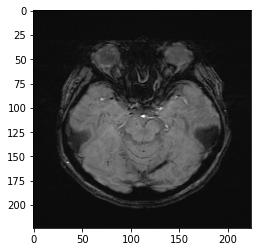

In [3]:
path = [
    '20230223_Nigrosome_Source_image_3T_20230223/PD_145',
        '20230223_Nigrosome_Source_image_3T_20230223/Control_104/',
       ]

target_names = [ 'Control','Loss+Partial']
data = []
label = []
data_v = []
label_v = []

val_list = [
    '2101943_control', '1592459_control', '4565496_control', '6596420_control', '4333688_control',
    '6411783_control','2852721_control','3004757_control','1687869_control','2995038_control',
    '6698123_Loss','2986279_loss','6587364_Loss','6537904_Loss','3202953_loss',
    '1523990_Partial','2954867_partial','3398934_partial','1407449_Partial','5274590_Partial',
    '6395300_loss','5793476_Loss','4251600_partial','3709154_Loss','5428639_Partial'
]
rr=0

for e,k in enumerate(path): 
    cou = 1
    for root, dirs, files in os.walk(k, topdown=False):
        flie_name = root.split('/')[-1]
        if flie_name in val_list:
            rr+=1
            for name in files[:5]: 
                if "measurement" not in os.path.join(root, name):
                    temp = os.path.join(root, name)
                    img = cv2.resize(cv2.imread(temp), (size, size)) 
                    plt.imshow(img)
                    data_v.append(img)
                    label_v.append(e if e==0 else 1)  
        else:
            for name in files[:5]: 
                if "measurement" not in os.path.join(root, name):
                    temp = os.path.join(root, name)
                    img = cv2.resize(cv2.imread(temp), (size, size)) 
                    data.append(img)
                    label.append(e if e==0 else 1) 
#                 cou+=1
print(rr)       
data = np.array(data)
label = np.array(label).reshape(-1,1)
n_classes = label.shape[1]
print(data.shape)
print(label.shape)

data_v = np.array(data_v)
label_v = np.array(label_v).reshape(-1,1)
n_classes_v = label_v.shape[1]
print(data_v.shape)
print(label_v.shape)
print(collections.Counter(label.reshape(-1)))
print(collections.Counter(label_v.reshape(-1)))

In [4]:
ftype = tf.float32
itype = tf.int32
num_classes = 2
hidden_dim = 512
input_num = 7*7*320

def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), dtype=ftype)
def bias_variable(shape, scale=0.1):
    return tf.Variable(np.ones(shape)*scale, dtype=ftype)
def convolution(x, w, b):
    conv = tf.nn.relu(tf.nn.conv2d(x, w, strides=[1,1,1,1], padding="SAME") + b)
    return tf.nn.max_pool(conv, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

class MLPModel:
    def __init__(self, keep_prob=None):
        self.keep_prob = keep_prob if keep_prob is None else tf.placeholder_with_default(1.0, [])
        self.weights = []
        self.biases = []
        self.w_fc1 = weight_variable([input_num, hidden_dim])
        self.b_fc1 = bias_variable([hidden_dim])
        self.weights.append(self.w_fc1)
        self.biases.append(self.b_fc1)
        self.w_fc3 = weight_variable([hidden_dim, hidden_dim])
        self.b_fc3 = bias_variable([hidden_dim])
        self.weights.append(self.w_fc3)
        self.biases.append(self.b_fc3)
        self.w_fc4 = weight_variable([hidden_dim, hidden_dim])
        self.b_fc4 = bias_variable([hidden_dim])
        self.weights.append(self.w_fc4)
        self.biases.append(self.b_fc4)
        self.w_fc5 = weight_variable([hidden_dim, hidden_dim])
        self.b_fc5 = bias_variable([hidden_dim])
        self.weights.append(self.w_fc5)
        self.biases.append(self.b_fc5)
        self.w_fc2 = weight_variable([hidden_dim, num_classes])
        self.b_fc2 = bias_variable([num_classes])
        self.weights.append(self.w_fc2)
        self.biases.append(self.b_fc2)
    def __call__(self, input_tensor):
        h_fc1 = tf.nn.relu(tf.matmul(input_tensor, self.w_fc1) + self.b_fc1)
        h_fc1 = tf.nn.dropout(h_fc1, keep_prob=self.keep_prob)
        h_fc3 = tf.nn.relu(tf.matmul(h_fc1, self.w_fc3) + self.b_fc3)
        h_fc3 = tf.nn.dropout(h_fc3, keep_prob=self.keep_prob)
        h_fc4 = tf.nn.relu(tf.matmul(h_fc3, self.w_fc4) + self.b_fc4)
        h_fc4 = tf.nn.dropout(h_fc4, keep_prob=self.keep_prob)
        h_fc5 = tf.nn.relu(tf.matmul(h_fc4, self.w_fc5) + self.b_fc5)
        h_fc5 = tf.nn.dropout(h_fc5, keep_prob=self.keep_prob)
        logits = tf.matmul(h_fc5, self.w_fc2) + self.b_fc2
        return logits


In [5]:
def VAT(input_tensor, network, network_to_approximate=None, xi=1e-6, epsilon=2.0, weight=1.0, num_approximation=1, clip_value_min=1e-30, dtype=tf.float32):
    """
    https://arxiv.org/abs/1704.03976
    ===input===
    input_tensor           : input tensor of network
    network                : function that receives input_tensor and returns the logits (i.e., the output without softmax.)
    network_to_approximate : function only to approximate the virtual adversarial perturbation
                             this may be useful when you want network to behave differently from the usual training part at some points such like dropout.
                             if this is None (default), this is same as "network."
    xi                     : scale of perturbation that is used to approximate the virtual adversarial perturbation. (default: 1e-6)
    epsilon                : scale of virtual adversarial perturbation. results can be sensitive at this number. (default: 2.0)
    weight                 : weight of loss. (default: 1.0)
    num_approximation      : number of iteration to approximate the virtual adversarial perturbation. (default: 1)
    clip_value_min         : this is for clipping some values that 
    is divisor or given to log. (default: 1e-30)
    dtype                  : dtype of tensors in this function. (default: tf.float32)
    ===output===
    vat_cross_entropy      : virtual adversarial loss
    vat_perturbation       : virtual adversarial perturbation
    """

    if network_to_approximate is None:
        network_to_approximate = network
        isSameNetwork = True
    else:
        isSameNetwork = False

    clipped = lambda x: tf.maximum(x, clip_value_min)

    axis_without_batch_size = tuple(range(1,len(input_tensor.get_shape())))
    if len(axis_without_batch_size) == 1: axis_without_batch_size = axis_without_batch_size[0]
    normalized = lambda x: x / clipped(tf.norm(x, axis=axis_without_batch_size, keep_dims=True))

    plain_softmax = tf.nn.softmax(network_to_approximate(input_tensor))
    perturbation = xi * normalized(tf.random_normal(shape=tf.shape(input_tensor), dtype=dtype))
    for i in range(num_approximation):
        softmax_accommodating_perturbation = tf.nn.softmax(network_to_approximate(input_tensor + perturbation))
        cross_entropy_accommodating_perturbation = -tf.reduce_sum(plain_softmax * tf.log(clipped(softmax_accommodating_perturbation)/plain_softmax), reduction_indices=1) * weight
        adversarial_direction = tf.gradients(cross_entropy_accommodating_perturbation, [perturbation])[0]
        vat_perturbation = normalized(adversarial_direction)
        perturbation = xi * vat_perturbation

    current_softmax = tf.nn.softmax(network(input_tensor)) if not isSameNetwork else plain_softmax
    current_softmax = tf.stop_gradient(current_softmax)
    vat_perturbation = tf.stop_gradient(epsilon * vat_perturbation)
    vat_softmax = tf.nn.softmax(network(input_tensor + vat_perturbation))
    vat_cross_entropy = tf.reduce_mean(-tf.reduce_sum(current_softmax * tf.log(clipped(vat_softmax)/current_softmax), reduction_indices=1))
    return vat_cross_entropy, vat_perturbation
def cross_entropy_and_accuracy(feed_dict):
    global sess, train_loss, accuracy, update_accuracy
    sess.run(tf.local_variables_initializer())
    loss, _ ,scor,pred= sess.run([cross_entropy, update_accuracy,s_logits,predictions], feed_dict=feed_dict)
    acc = sess.run(accuracy)
    return loss, acc,scor,pred



  2%|▏         | 19/896 [00:00<00:04, 188.85it/s]

au
ex
Processing fold # 0
aug...


100%|██████████| 896/896 [00:04<00:00, 198.61it/s]


ex...
last layer output shape: (None, 7, 7, 320)


0it [00:00, ?it/s]


last layer output shape: (None, 7, 7, 320)
(1792, 15680)
(1792, 15680)
(1917, 15680)


good,test_loss 1.110028, test_acc 0.808000, F1 0.804382, recall 0.840000,: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s]
<ipython-input-6-14ad4e6ef173>:139: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr,fpr,tpr))


best:
test_acc: 0.808 F1: 0.8043818466353676 recall: 0.84
saving..
roc_auc: 0.8758666666666667
Processing fold # 1


  3%|▎         | 25/896 [00:00<00:03, 247.56it/s]

aug...


100%|██████████| 896/896 [00:04<00:00, 198.72it/s]


ex...
last layer output shape: (None, 7, 7, 320)


0it [00:00, ?it/s]


last layer output shape: (None, 7, 7, 320)
(1792, 15680)
(1792, 15680)
(1917, 15680)


/nfs/Workspace/venv/lib/python3.8/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
good,test_loss 2.143916, test_acc 0.776000, F1 0.765038, recall 0.700000,: 100%|██████████| 100/100 [00:23<00:00,  4.32it/s]
<ipython-input-6-14ad4e6ef173>:139: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr,fpr,tpr))
  2%|▏         | 19/896 [00:00<00:04, 179.18it/s]

best:
test_acc: 0.776 F1: 0.7650375939849624 recall: 0.7
roc_auc: 0.8309333333333334
Processing fold # 2
aug...


100%|██████████| 896/896 [00:04<00:00, 195.14it/s]


ex...
last layer output shape: (None, 7, 7, 320)


0it [00:00, ?it/s]


last layer output shape: (None, 7, 7, 320)
(1792, 15680)
(1792, 15680)
(1917, 15680)


/nfs/Workspace/venv/lib/python3.8/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
good,test_loss 1.863031, test_acc 0.840000, F1 0.820711, recall 0.640000,: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s]
<ipython-input-6-14ad4e6ef173>:139: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr,fpr,tpr))


best:
test_acc: 0.84 F1: 0.8207114170969594 recall: 0.64
saving..
roc_auc: 0.8558666666666667
Processing fold # 3


  2%|▏         | 17/896 [00:00<00:05, 163.05it/s]

aug...


100%|██████████| 896/896 [00:04<00:00, 186.69it/s]


ex...
last layer output shape: (None, 7, 7, 320)


0it [00:00, ?it/s]


last layer output shape: (None, 7, 7, 320)
(1792, 15680)
(1792, 15680)
(1917, 15680)


/nfs/Workspace/venv/lib/python3.8/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
good,test_loss 1.028708, test_acc 0.808000, F1 0.795417, recall 0.700000,: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]
<ipython-input-6-14ad4e6ef173>:139: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr,fpr,tpr))
  3%|▎         | 23/896 [00:00<00:03, 224.55it/s]

best:
test_acc: 0.808 F1: 0.795417348608838 recall: 0.7
roc_auc: 0.8936000000000001
Processing fold # 4
aug...


100%|██████████| 896/896 [00:04<00:00, 197.69it/s]


ex...
last layer output shape: (None, 7, 7, 320)


0it [00:00, ?it/s]


last layer output shape: (None, 7, 7, 320)
(1792, 15680)
(1792, 15680)
(1917, 15680)


/nfs/Workspace/venv/lib/python3.8/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
good,test_loss 1.066830, test_acc 0.816000, F1 0.797264, recall 0.640000,: 100%|██████████| 100/100 [00:22<00:00,  4.45it/s]

best:
test_acc: 0.816 F1: 0.7972639447147591 recall: 0.64
roc_auc: 0.8710666666666667



<ipython-input-6-14ad4e6ef173>:139: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr,fpr,tpr))


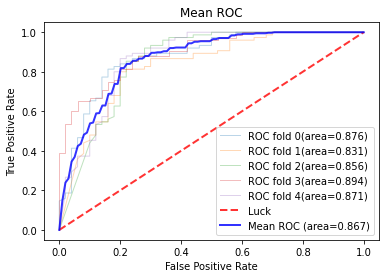

Avg_F1: 0.7965624302081773
Avg_Acc: 0.809600007534027
Avg_recall: 0.704


In [6]:
s = np.arange(label.shape[0])
np.random.shuffle(s)
data = data[s]
label = label[s]

K = 5
num_val_samples = int(len(data)/K)
f1_avg=0.0
acc_avg=0.0
re_avg=0.0

tprs=[]
aucs=[]
mean_fpr=np.linspace(0,1,100)
aug = True
ex = True
print("au" if aug==True else "noau")
print("ex" if ex==True else "noex")
cm=[]
best_F1_=0
for i in range(K):
    print('Processing fold #', i)
    x_test = data_v/255.
    x_test = x_test.astype('float32')
    y_test = label_v
    y_test = np.eye(2)[y_test].reshape(-1,2)
    if K!=1:
        x_train = np.concatenate( 
                             [data[: i*num_val_samples],
                             data[(i+1)*num_val_samples :]],
                             axis = 0)
        y_train = np.concatenate(
                             [label[: i*num_val_samples],
                             label[(i+1)*num_val_samples :]],
                             axis = 0)
    else:
        x_train = data
        y_train = label
    if aug:
        print("aug...")
        aug_img =[]
        aug_y = []
        for c in tqdm(range(x_train.shape[0])):   
            for j in range(1):              
                aug_img.append(preprocessing_function(x_train[c].reshape(size,size,3)))
                aug_y.append(y_train[c].reshape(1))
        x_train = np.concatenate((x_train,np.array(aug_img)))
        y_train = np.concatenate((y_train,np.array(aug_y)))
    t = np.arange(y_train.shape[0])
    np.random.shuffle(t)
    x_train = x_train[t]/255.
    y_train = y_train[t]
    y_train = np.eye(2)[y_train].reshape(-1,2)
    if ex: 
        print("ex...")
        train_ex = get_feature(efn.EfficientNetB0,x_train[:10000])
        for ind in tqdm(range(10000,len(x_train),10000)):
            train_ex_ = get_feature(efn.EfficientNetB0,x_train[ind:ind+10000])
            train_ex = np.concatenate((train_ex,train_ex_))
        test_ex = get_feature(efn.EfficientNetB0,x_test)
            
    else:
        train_ex = x_train.reshape(-1,size*size*3)
        test_ex = x_test.reshape(-1,size*size*3)


    train_num = train_ex.shape[0]
    test_num = test_ex.shape[0]
    
    all_ = np.concatenate((train_ex,test_ex),axis = 0)
    train_ex = all_[:train_num].astype('float32')
    test_ex = all_[train_num:].astype('float32')
    ss = np.arange(all_.shape[0])
    np.random.shuffle(ss)
    all_ = all_[ss].astype('float32')
    print(train_ex.shape)
    print(train_ex.shape)
    print(all_.shape)
    
    tf.reset_default_graph()
    network = MLPModel(keep_prob=0.7)
    x = tf.placeholder(ftype, [None, input_num])
    x_v = tf.placeholder(ftype, [None, input_num])
    gt = tf.placeholder(itype, [None, 2])
    logits = network(x)
    logits_ = network(x_v)
    s_logits = tf.nn.softmax(logits)
    s_logits_ = tf.nn.softmax(logits_)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=gt, logits=logits))
    vat_cross,_ = VAT(x_v,network)
    train_loss = 0.999*cross_entropy+0.001*vat_cross
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(train_loss)
    predictions = tf.argmax(logits, axis=1)
    accuracy, update_accuracy = tf.metrics.accuracy(labels=tf.argmax(gt, axis=1), predictions=predictions)

    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    vl = [v for v in tf.global_variables() if "Adam" not in v.name]
    saver = tf.train.Saver(var_list=vl)
    best_acc=0.00
    best_F1=0.0
    best_re=0.00
    cm_best = []
    y_test_ = []
    sco = []
    pbar = tqdm(range(100)) 
    for epoch in pbar:
        ff = int(y_test.shape[0]/y_train.shape[0])
        for b in range(0, y_train.shape[0], 32):   
            fd = {x:train_ex[b:b+32], gt:y_train[b:b+32],x_v:all_[b*ff:(b+32)*ff]}
            _,loss_ = sess.run([train_op,train_loss], feed_dict=fd)
        loss, acc,l,p = cross_entropy_and_accuracy({x:test_ex, gt:y_test})
        co_m = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=p)
        f1 = f1_score(y_true=np.argmax(y_test, axis=1), y_pred=p, average='macro')
        re = metrics.recall_score(y_true=np.argmax(y_test, axis=1), y_pred=p)
        if f1>best_F1:
            best_F1 = f1
            best_acc = acc
            best_re = re
            y_test_= y_test
            sco = l
            cm_best = co_m
            pbar.set_description("good,test_loss %f, test_acc %f, F1 %f, recall %f," % (loss,acc,f1,re))
            save_path = saver.save(sess, "./PD_model_"+str(i)+"/model.ckpt")
    cm.append(cm_best)
    print("best:")
    print("test_acc:",best_acc,"F1:",best_F1,"recall:",best_re)
    if best_F1>best_F1_:
        best_F1_=best_F1
        print("saving..")
        save_path = saver.save(sess, "./PD_model/model.ckpt")
    f1_avg+=best_F1
    acc_avg+=best_acc
    re_avg+= best_re
    fpr,tpr,thresholds=roc_curve(y_test_[:,0],sco[:,0])

    tprs.append(interp(mean_fpr,fpr,tpr))
    tprs[-1][0]=0.0
    roc_auc=auc(fpr,tpr)
    print("roc_auc:",roc_auc)
    aucs.append(roc_auc)
    
    plt.plot(fpr,tpr,lw=1,alpha=0.3,label='ROC fold %d(area=%0.3f)'% (i,roc_auc))
plt.plot([0,1],[0,1],linestyle='--',lw=2,color='r',label='Luck',alpha=.8)
mean_tpr=np.mean(tprs,axis=0)
mean_tpr[-1]=1.0
mean_auc=auc(mean_fpr,mean_tpr)#计算平均AUC值
std_auc=np.std(tprs,axis=0)
plt.plot(mean_fpr,mean_tpr,color='b',label=r'Mean ROC (area=%0.3f)'%mean_auc,lw=2,alpha=.8)
std_tpr=np.std(tprs,axis=0)
tprs_upper=np.minimum(mean_tpr+std_tpr,1)
tprs_lower=np.maximum(mean_tpr-std_tpr,0)
# plt.fill_between(mean_tpr,tprs_lower,tprs_upper,color='gray',alpha=.2)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC')
plt.legend(loc='lower right')
if mean_auc>=0.93:
    plt.savefig('None.png',dpi=600)
plt.show()     


print("Avg_F1:",f1_avg/K)
print("Avg_Acc:",acc_avg/K)
print("Avg_recall:",re_avg/K)

(125, 224, 224, 3)
(125, 1)
last layer output shape: (None, 7, 7, 320)
INFO:tensorflow:Restoring parameters from ./PD_model_0/model.ckpt


/nfs/Workspace/venv/lib/python3.8/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./PD_model_1/model.ckpt
INFO:tensorflow:Restoring parameters from ./PD_model_2/model.ckpt
INFO:tensorflow:Restoring parameters from ./PD_model_3/model.ckpt
INFO:tensorflow:Restoring parameters from ./PD_model_4/model.ckpt
(25, 2)
[[14  1]
 [ 2  8]]
f1: 0.8726655348047538
re: 0.8
acc: 0.88
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.89      0.80      0.84        10

    accuracy                           0.88        25
   macro avg       0.88      0.87      0.87        25
weighted avg       0.88      0.88      0.88        25



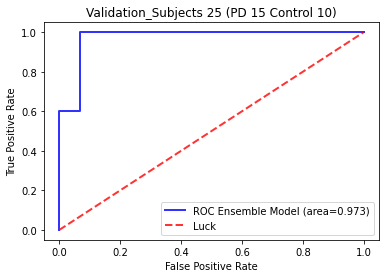

Confusion matrix, without normalization
[[14  1]
 [ 2  8]]


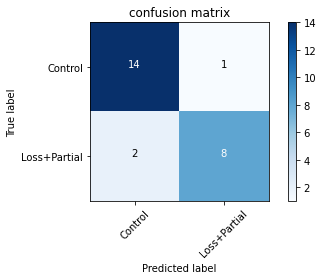

In [10]:
v_data = data_v
K = 5
v_data = np.array(v_data)
v_label = label_v
n_classes = v_label.shape[1]
print(v_data.shape)
print(v_label.shape)
collections.Counter(v_label.reshape(-1))
v_data = v_data/255.
v_label = np.eye(2)[v_label].reshape(-1,2)

v_data_ex = get_feature(efn.EfficientNetB0,v_data)
tf.reset_default_graph()
network = MLPModel(keep_prob=0.7)
x = tf.placeholder(ftype, [None, input_num])
x_v = tf.placeholder(ftype, [None, input_num])
gt = tf.placeholder(itype, [None, 2])
logits = network(x)
logits_ = network(x_v)
s_logits = tf.nn.softmax(logits)
s_logits_ = tf.nn.softmax(logits_)
#     entropy = tf.reduce_mean(tf.reduce_sum(tf.clip_by_value(s_logits_,0.1,1.0)*tf.clip_by_value(tf.log(s_logits_),0.1,1.0),axis=1))
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=gt, logits=logits))
vat_cross,_ = VAT(x_v,network)
train_loss = 0.99999*cross_entropy+0.00001*vat_cross
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(train_loss)
predictions = tf.argmax(logits, axis=1)
accuracy, update_accuracy = tf.metrics.accuracy(labels=tf.argmax(gt, axis=1), predictions=predictions)
l__ = 0
for g in range(K):
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    vl = [v for v in tf.global_variables() if "Adam" not in v.name]
    saver = tf.train.Saver(var_list=vl)
    saver.restore(sess, "./PD_model_"+str(g)+"/model.ckpt")

    loss, acc,l,p = cross_entropy_and_accuracy({x:v_data_ex, gt:v_label})
    l_fold = l.reshape(25,5,2)
    l_fold = np.sum(l_fold,axis=1)/5.
    v_label_fold = np.array([x for e,x in enumerate(v_label) if e%5==0])
    fpr_,tpr_,thresholds_=roc_curve(v_label_fold[:,1],l_fold[:,1])
    roc_auc_=auc(fpr_,tpr_)
    if g==0:l*50
    l__+= l
#     plt.plot(fpr_,tpr_,lw=1,alpha=0.3,label='ROC model %d(area=%0.3f)'% (g+1,roc_auc_))


l= l__/5.
l = l.reshape(25,5,2)
l = np.sum(l,axis=1)/5.

print(l.shape)

p =  np.argmax(l,axis=1)
v_label_ = [x for e,x in enumerate(np.argmax(v_label, axis=1)) if e%5==0]
v_label = np.array([x for e,x in enumerate(v_label) if e%5==0])
co_m = confusion_matrix(y_true=v_label_, y_pred=p)
f1 = f1_score(y_true=v_label_, y_pred=p, average='macro')
re = metrics.recall_score(y_true=v_label_, y_pred=p)
acc = metrics.accuracy_score(v_label_, y_pred=p)
report = metrics.classification_report(v_label_,p)

print(co_m)
print("f1:",f1)
print("re:",re)
print("acc:",acc)
print(report)


fpr,tpr,thresholds=roc_curve(v_label[:,1],l[:,1])

roc_auc=auc(fpr,tpr)

plt.plot(fpr,tpr,lw=2,alpha=0.8,color='b',
         label='ROC Ensemble Model (area=%0.3f)'% (roc_auc))

plt.plot([0,1],[0,1],linestyle='--',lw=2,color='r',label='Luck',alpha=.8)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation_Subjects 25 (PD 15 Control 10)')
plt.legend(loc='lower right')
plt.savefig('Validation_Subjects 25 (PD 15 Control 10).png',dpi=600)
plt.show()   


plt.figure()
plot_confusion_matrix(co_m, classes=target_names,normalize=False,
                    title="confusion matrix")
plt.savefig('Validation_Subjects 25 (Total 15 loss Control 10)_cm.png',dpi=600)
plt.show()  


# plt.title('Validation_Subjects 28 (Total loss 14 Partial loss 14)')
# plt.legend(loc='lower right')
# plt.savefig('Validation_Subjects 28 (Total loss 14 Partial loss 14).png',dpi=600)
# plt.show()   


# plt.figure()
# plot_confusion_matrix(co_m, classes=target_names,normalize=False,
#                     title="confusion matrix")
# plt.savefig('Validation_Subjects 28 (Total loss Control 12)_cm.png',dpi=600)

In [11]:
v_label[:,1],l[:,1]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]),
 array([4.10716459e-02, 6.85003633e-03, 3.15470457e-01, 6.07362866e-01,
        1.01409420e-01, 2.67661721e-01, 4.14313972e-02, 1.60912815e-02,
        4.04577258e-06, 4.09345254e-02, 1.14304304e-01, 4.01638746e-02,
        3.11746538e-01, 5.58464453e-02, 2.18506958e-02, 9.62934494e-01,
        5.05714238e-01, 3.27490807e-01, 8.34574878e-01, 9.84331787e-01,
        9.99914825e-01, 8.38182330e-01, 5.35888374e-01, 4.00970846e-01,
        6.82831883e-01], dtype=float32))

In [12]:
control = [x for e,x in enumerate(l[:,1]) if v_label[:,1][e] ==0]
PD = [x for e,x in enumerate(l[:,1]) if v_label[:,1][e] ==1]
for i in control:
    print(i)
print("????")
for i in PD:
    print(i)

0.041071646
0.0068500363
0.31547046
0.60736287
0.10140942
0.26766172
0.041431397
0.016091282
4.0457726e-06
0.040934525
0.114304304
0.040163875
0.31174654
0.055846445
0.021850696
????
0.9629345
0.50571424
0.3274908
0.8345749
0.9843318
0.9999148
0.83818233
0.5358884
0.40097085
0.6828319
